In [26]:
# Imports

!pip install numdifftools



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import numpy as np
import numdifftools as nd
import random
import heapq
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from collections import Counter

In [28]:
#np.random.seed(1)
#random.seed(1)
#np.seterr(all='raise')


In [29]:
def partial_function(f___,input,pos,value):
    tmp  = input[pos]
    input[pos] = value
    ret = f___(*input)
    input[pos] = tmp
    return ret

def partial_derivative(f,input):
    return [2*x for x in input]  # For now, we only deal with L2 norm, so just return this
#    ret = np.empty(len(input))
#    for i in range(len(input)):
#        fg = lambda x:partial_function(f,input,i,x)
#        ret[i] = nd.Derivative(fg)(input[i])
#    return ret


In [30]:
def draw_plot(losses, queries, imgname = None, algorithm = None):
     x = np.asarray(queries)
     y = np.asarray(losses)

     fig, ax = plt.subplots()
     ax.plot(x, y, marker='o', color='b')
     #ax.legend()
     ax.set_xscale('log')
     ax.set_yscale('log')
     ax.set(xlabel='Total Queries', ylabel='Loss',
         title=f'Performance of {algorithm}')
     ax.grid()
     if imgname:
       fig.savefig(f"../plots/{imgname}")
     plt.show()


In [32]:
# This function generates the test cases in the experiment
def generate_Ax_test(n, d):
  mu = np.array([[np.random.default_rng().pareto(0.5) for i in range(n)]])
  x = np.array([[np.random.default_rng().uniform(low = 0.5, high = 1) for i in range(d)]])
  mu = mu * (20 / np.max(mu)) # normalize 
  A = mu.T @ x / (np.linalg.norm(x)**2) 
  Z = np.random.normal(0, 1/d, size=(n, d))
  A = A+Z
  ones = np.ones((d, 1))
  B = (A @ x.T - mu.T )
  A = A - ( B @ ones.T) / np.sum(x)
  return A , mu.T, x[0]
 

In [33]:
# Simulates arm sampling in the Ax case
def sample_arm(A,i,d,x,sample_count,guessed, random = False):
  possibility = []
  picked = []
  for j in range(d):
    possibility.append(d * A[i,j] * x[j])
  if random:
    return np.average(np.random.choice(possibility, size = sample_count, replace = False)) , -1
  return np.average(possibility[int(guessed+1):int(min(guessed+sample_count+1,d+1))]),   int(min(guessed+sample_count+1,d+1)-1)


In [35]:
def adaptive_function_approximation(A,k,x,n, f , epsilon, delta, target_mu):
  """
  This is Algorithm1, modified to perform optimally in the ||Ax||_2^2 setting (read the report for more details) 
  """
  budget = n
  runbudget = 0
  r = 1
  guessed_set = [0 for i in range(n)]
  guessed_id = [-1 for i in range(n)]
  guessed_total = [0 for i in range(n)] 
  L = 1
  tot = 0
  uniform_loss = []
  query_uniform = []
  query_history = []
  losses = []
  while True:
    curr_budget = np.ceil(budget*(((2)**(r-1))))

    alloc = np.ceil(curr_budget/n)
    
    for i in range(n):
        if guessed_total[i] >= k:
          pass
        elif guessed_total[i] + alloc >= k:
          new_batch, new_id = sample_arm(A,i,k,x,k,-1)
          guessed_set[i] = new_batch
          guessed_total[i] =  guessed_total[i] + k
        else:
          new_batch, new_id = sample_arm(A,i,k,x,alloc,guessed_id[i])
          guessed_set[i] = (guessed_set[i] * guessed_total[i] + new_batch * alloc) / (guessed_total[i] + alloc)
          guessed_id[i] = new_id
          guessed_total[i] = guessed_total[i]+alloc

  
    guess_mu = guessed_set
    runbudget = guessed_total[0]
    C_r = np.sqrt(  (np.log(1.0 / delta)) /runbudget)

    g = partial_derivative(f,guess_mu)
    gL = [ max(abs(i) - C_r, 0.0001) for i in g]
    gU = [ abs(i) + C_r for i in g]
    sums = sum(gL)

    ai = [float(i)/float(sums) for i in gL]
    Ti = [min(r,10) * curr_budget * ai[i] for i in range(n)]

    final_set = [0 for i in range(n)]
    final_total = [0 for i in range(n)]

    for z in range(n):
      if guessed_total[z] >= k:
        final_set[z] = guessed_set[z]
        final_total[z] = guessed_total[z]
      elif guessed_total[z] + Ti[z] >= k:
        new_batch, new_id = sample_arm(A,z,k,x,k, -1)
        final_set[z] = new_batch
        final_total[z] = guessed_total[z] + k
      else:
        new_batch, new_id = sample_arm(A,z,k,x,np.ceil(Ti[z]), guessed_id[z])
        final_set[z] = (guessed_set[z] * guessed_total[z] + Ti[z] * new_batch ) / (guessed_total[z] + Ti[z])
        final_total[z] =  guessed_total[z] + Ti[z]

    check = sum([float(gU[i]**2) / float(final_total[i]) for i in range(n)])

    final_guess = final_set
    loss = abs(f(*final_guess) - f(*target_mu))
    losses.append(loss)
    query_history.append(sum(final_total))  
    if  check <= (epsilon**2) / (16 * np.log(6/delta)):
      for z in range(n):
        if guessed_total[z] >= k:
          pass 
        elif guessed_total[z] + Ti[z] >= k:
          new_batch, new_id = sample_arm(A,z,k,x,k, -1)
          guessed_set[z] = new_batch
          guessed_total[z] = guessed_total[z] + k
        else:
          new_batch, new_id = sample_arm(A,z,k,x,np.ceil(Ti[z]), guessed_id[z])
          guessed_set[z] = (guessed_set[z] * guessed_total[z] + Ti[z] * new_batch) / (Ti[z] + guessed_total[z])
          guessed_total[z] =  guessed_total[z] + Ti[z]
      final_guess = guessed_set
      loss = abs(f(*final_guess) - f(*target_mu))
      status = loss < epsilon
      losses.append(loss)
      query_history.append(sum(guessed_total))
      return loss, status,  np.ceil(sum(guessed_total)), final_guess, losses, query_history, uniform_loss, query_uniform
    else:
      r = r+1
      if r > 19:
         return loss, loss < epsilon,  np.ceil(sum(guessed_total)), final_guess, losses, query_history, uniform_loss, query_uniform



In [36]:
# This algorithm just sample the algorithm with a given quota
# T is the total computation budget
def uniform_guess(A,k,x,n, f, target_mu, epsilon, delta):
  starting = n
  runbudget = 0
  guess = [None for i in range(n)]
  losses = []
  queries = []
  L = 10
  r = 1
  guessed_set = [0 for i in range(n)]
  guessed_id = [-1 for i in range(n)]
  guessed_total = [0 for i in range(n)]
  while True:

    budget = starting // n
    runbudget = runbudget + budget

    for i in range(n):

      if budget >= k:
        for j in range(n):
          new_batch, new_id = sample_arm(A,j,k,x,k,-1)
          guessed_set[i] = new_batch
          guessed_id[i] = new_id
        losses.append(0)
        queries.append(queries[-1] + n * k)
        return losses, queries        

      else:
        new_batch, new_id = sample_arm(A,i,k,x,budget,guessed_id[i], random = True)
        guessed_set[i] = (guessed_set[i] * guessed_total[i] + new_batch * budget) / (guessed_total[i] + budget)
        guessed_id[i] = new_id
        guessed_total[i] = guessed_total[i] + budget
    
    C_r = np.sqrt(  (np.log(1.0 / delta)) /runbudget)
    guess_mu = guessed_set
    g = partial_derivative(f,guess_mu)
    sums = sum(g)

    ai = [float(i)/float(sums) for i in g]
    Ti = [min(r,10) * budget * ai[i] for i in range(n)]
    check = sum([float(g[i]**2) / float(Ti[i]) for i in range(n)])
    queries.append(sum(guessed_total))
    losses.append(abs(f(*guess_mu) - f(*target_mu)))
    if  check <  (epsilon**2) / (16 * np.log(6/delta)) :
      return losses, queries
    else:
      starting = starting * 2
      r = r+1
      if r > 19:
        return losses, queries


In [37]:
def convert_Ax_to_function(A):
  def f(*guess):
    ans = [0 for i in range(len(A))]
    for i in range(len(A)):
      ans[i] = np.dot(guess, A[i,:])
    
    return sum(o*o for o in ans)

  return f


In [38]:
# L2 norm squared
def power(*mu):
  return sum(o*o for o in mu)

In [39]:
# To keep track of losses
def experiment_adaptive(n,k,A,mu,x,epsilon,delta):

  mu = [i[0] for i in mu.tolist()] # for total derivative

  loss,status,total,guess,losses,history,uniform_loss, query_uniform = adaptive_function_approximation(A,k ,x,n, power , epsilon, delta, mu)
  true_loss = []
  true_uniform = []
  for l in losses:
    true_loss.append(l)
  losses = true_loss
  for l in uniform_loss:
    true_uniform.append(l)
  uniform_losses = true_uniform
  return losses,history


In [40]:
def experiment_uniform(n,k,A,mu,x,epsilon,delta):
  mu = [i[0] for i in mu.tolist()] # for total derivative

  curr = n
  losses = []
  queries = []
  losses ,queries = uniform_guess(A,k,x,n, power, mu,epsilon, delta)
  return losses, queries

In [41]:
# Find the theoretical gain of a test case
def gain(f,n, mu):
  par = partial_derivative(f, mu)
  return n * sum([o*o for o in par]) / (sum(par)**2)

In [42]:
# Conduct one round of test
def experiment( A, mu, x, n, k, epsilon, delta):
  loss,history= experiment_adaptive(n,k,A,mu,x,epsilon,delta)
  uniform_loss , uniform_history = experiment_uniform(n,k,A,mu,x,epsilon,delta)
  return loss, history, uniform_loss, uniform_history

In [43]:
n = 10
k = 10000
epsilon = 10**-4
delta  = 0.01
#l = []
#m = []
queries = []
uniform_queries = []
losses = []
uniform_losses = []
A,mu,x = generate_Ax_test(n, k)

for i in range(100):
  perm = np.random.permutation(k)
  idx = np.empty_like(perm)
  idx[perm] = np.arange(len(perm))
  A[:] = A[:, idx]
  x[:] = x[idx]
  
  loss, history, uniform_loss, uniform_history = experiment(A,mu,x,n,k,epsilon,delta)
  queries.append(history)
  uniform_queries.append(uniform_history)
  losses.append(loss)
  uniform_losses.append(uniform_loss)


#for j in m:
#  print(j)

In [44]:
def patch(arr):
  max_len = len(max(arr, key=len))
  ans = [l+[float('nan')]*(max_len-len(l)) for l in arr]
  return ans

In [45]:

losses = np.average(patch(losses), axis = 0)
uniform_losses = np.average(patch(uniform_losses), axis = 0)
queries = np.average(patch(queries), axis = 0)
uniform_queries = np.average(patch(uniform_queries), axis = 0)

print("actual_gain = ",  uniform_queries[-1] / queries[-1])


actual_gain =  1.4503325820460666


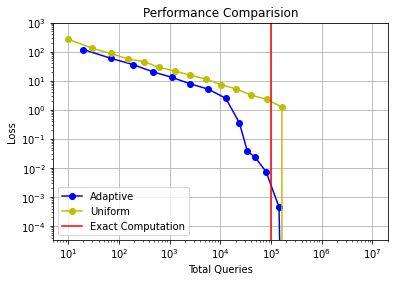

In [46]:
# Plot performance
xa = (queries)
ya = (losses)
xu = (uniform_queries)
yu = (uniform_losses)
fig, ax = plt.subplots()

ideal = n*k
plt.xlim([n/2.0,200*ideal])
plt.ylim([epsilon/3.0, 1000])
ax.plot(xa, ya, marker='o', color='b', label = "Adaptive")
ax.plot(xu, yu, marker='o', color='y', label = "Uniform")

  
ax.axvline(x=ideal, color = 'r', label = 'Exact Computation')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(xlabel='Total Queries', ylabel='Loss', title=f'Performance Comparision')
ax.grid()
ax.legend()
plt.show()

In [47]:
def adaptive_batch(n, f ,target_mu, epsilon, delta, rng):
  """
General version of Algorithm1
  """
  budget = n
  runbudget = 0
  r = 1
  guessed_set = [0 for i in range(n)] #keep track of guesses, actually only need to check average otherwise memory is toast 
  guessed_total = [0 for i in range(n)] 
  L = 1
  tot = 0
  query_history = []
  losses = []
  
  while True:
    curr_budget = np.ceil(budget*(2-rng/200)**(r-1))
    alloc = np.ceil(curr_budget/n)
    for i in range(n):
      guessed_set[i] =  ( guessed_set[i] * guessed_total[i] + alloc * np.random.normal(loc = target_mu[i] , scale = 1/(alloc**0.5)) ) / (alloc + guessed_total[i])
      guessed_total[i] = guessed_total[i] + alloc
    
    guess_mu = guessed_set
    runbudget = guessed_total[0]
    C_r = np.sqrt(  (np.log(1.0 / delta)) /runbudget)

    g = partial_derivative(f,guess_mu)
    gL = [ max(abs(i) - C_r, 0.00001) for i in g]
    gU = [ abs(i) +  C_r for i in g]
    sums = sum(gL)
   
    ai = [float(i)/float(sums) for i in gL]
    Ti = [np.ceil(min(r,10) * curr_budget * ai[i]) for i in range(n)]
    
    gs = [0 for i in range(n)]
    gt = [0 for i in range(n)]
    for z in range(n):
      gs[z] =  ( guessed_set[z] * guessed_total[z] + Ti[z] * np.random.normal(loc = target_mu[z] , scale = 1/(Ti[z]**0.5)) ) / (guessed_total[z] + Ti[z])
      gt[z] = guessed_total[z] + Ti[z]
    final_guess = gs
    loss = abs(f(*final_guess) - f(*target_mu))
    status = loss < epsilon
    losses.append(loss)
    query_history.append(sum(gt))
    check = sum([float(gU[i]**2) / float(guessed_total[i] + Ti[i]) for i in range(n)])

    if  check <= (epsilon**2) / (16 * np.log(1/delta)):

      for z in range(n):
        guessed_set[z] =  ( guessed_set[z] * guessed_total[i] + Ti[z] * np.random.normal(loc = target_mu[z] , scale = 1/(Ti[z]**0.5)) ) / (guessed_total[z] + Ti[z])
        guessed_total[z] = guessed_total[z] + Ti[z]
     
      final_guess = guessed_set
      loss = abs(f(*final_guess) - f(*target_mu))
      status = loss < epsilon
      losses.append(loss)
      query_history.append(sum(guessed_total))
      return guessed_set, losses, query_history, guessed_total
    else:
      r = r+1
      
      


In [48]:
# Uniform sampling for the general case
def uniform_batch(n, f, target_mu, epsilon, delta, rng):
  
  starting = n
  runbudget = 0
  losses = []
  queries = []
  L = 1
  r = 1
  guessed_set = [0 for i in range(n)]
  guessed_total = [0 for i in range(n)]
  while True:
    budget = np.ceil(starting / n)
    runbudget = runbudget + budget

    for i in range(n):
      guessed_set[i] =  ( guessed_set[i] * guessed_total[i] + budget * np.random.normal(loc = target_mu[i] , scale = 1/(budget**0.5)) ) / (budget + guessed_total[i])
      guessed_total[i] = guessed_total[i] + budget
    
    C_r = np.sqrt(  (np.log(1.0 / delta)) /runbudget)
    guess_mu = guessed_set
    g = partial_derivative(f,guess_mu)
    sums = sum(g)
    gU = [ abs(i) +  C_r for i in g]

    check = sum([float(gU[i]**2) / float(guessed_total[i]) for i in range(n)])

    queries.append(sum(guessed_total))
    losses.append(abs(f(*guess_mu) - f(*target_mu)))
    if  check <  (epsilon**2) / (16 * np.log(1/delta)) :
      return losses, queries, guessed_total
    else:
      starting = starting * (2-(rng/200))
      r = r+1


In [49]:
# Plot the gains per test
def plot_gains(n = 100, k = 10000,epsilon = 10**-4,delta  = 0.01, points = 10, trials = 20):
  queries = []
  uniform_queries = []
  proj = []
  act = []
  pts = []
  for i in range(points):
    A , mu , x = generate_Ax_test(n,k)
    mu = mu.T[0]
    data_q = []
    data_uq = []
    for j in range(trials):
      rng = np.random.randint(0,100) 
      e, l, q, t = adaptive_batch(n, power , mu,epsilon, delta, rng)      
      ul, uq, ut = uniform_batch(n, power , mu,epsilon, delta, rng)      
      assert(l[-1] < epsilon)
      assert(ul[-1] < epsilon)
      data_q.append(q[-1])
      data_uq.append(uq[-1])

    proj_gain = gain(power,n,mu)
    act_gain = np.mean(data_uq) / np.mean(data_q)
    proj.append(proj_gain)
    act.append(act_gain)
    pts.append([proj_gain,act_gain])
  plt.figure(figsize = (10,10))
  plt.ylabel('Empirical adaptive gain')
  plt.xlabel('Theoretical adaptive gain')
  plt.xlim((0.9, n*1.1)) # restricts x axis from 0 to 25
  plt.ylim((0.9, n*1.1)) # restricts x axis from 0 to 25
  plt.plot([0.9, n*1.1], [0.9,n*1.1], '--r', color = 'b', label = 'Ideal line') # plots line y = x
  plt.scatter(proj,act, color = 'r')

  return proj,act






Empirical gain ratio [0.81225673]


<ipython-input-49-d6656be644f2>:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0.9, n*1.1], [0.9,n*1.1], '--r', color = 'b', label = 'Ideal line') # plots line y = x


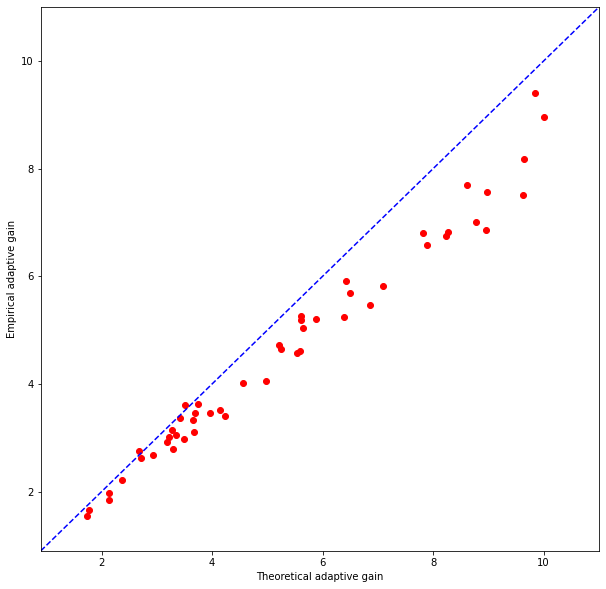

In [50]:
# plot and see the gradient matches the hypothesis in report
proj, act = plot_gains(n = 10, k = 10000 , points = 50)
proj = [[i] for i in proj]
model = LinearRegression().fit(proj,act)
x = model.coef_
print("Empirical gain ratio", x)

In [51]:
def adaptive_thresholding(n, f ,target_mu, threshold, delta, rng):
  """
  Algorithm1 for the thresholding variant
  """
  budget = n
  runbudget = 0
  r = 1
  guessed_set = [0 for i in range(n)] 
  guessed_total = [0 for i in range(n)] 
  L = 1
  tot = 0
  query_history = []
  losses = []

  while True:
    curr_budget = np.ceil(budget*(2-rng/200)**(r-1))
    alloc = np.ceil(curr_budget/n)
    for i in range(n):
      guessed_set[i] =  ( guessed_set[i] * guessed_total[i] + alloc * np.random.normal(loc = target_mu[i] , scale = 1/(alloc**0.5)) ) / (alloc + guessed_total[i])
      guessed_total[i] = guessed_total[i] + alloc    
    guess_mu = guessed_set
    runbudget = guessed_total[0]

    g = partial_derivative(f,guess_mu)
    C_r = np.sqrt(  (np.log(1.0 / delta)) /runbudget)

    gL = [ max(abs(i) - C_r, 0.00001) for i in g]
    gU = [ abs(i) +  C_r for i in g]
    sums = sum(gL)
   
    ai = [float(i)/float(sums) for i in gL]
    Ti = [np.ceil(min(r,10) * curr_budget * (ai[i]+1/n)) for i in range(n)]
    
    gs = [0 for i in range(n)]
    gt = [0 for i in range(n)]
    for z in range(n):
      gs[z] =  np.random.normal(loc = target_mu[z] , scale = 1/(Ti[z]**0.5)) 
      gt[z] = Ti[z]
    final_guess = gs
    loss = abs(f(*final_guess) - f(*target_mu))
    status = loss < epsilon
    losses.append(loss)
    query_history.append(sum(gt))
    check = sum([float(gU[i]**2) / float(guessed_total[i] + Ti[i]) for i in range(n)])
    Crf1 = np.sqrt(2 * np.log(24.0 * r * r / delta ) * check)
    Crf2 = (L * n * np.log(24.0 * r * r / delta )) / runbudget
    Crf = Crf1+Crf2 
    bound = abs(f(*final_guess) - threshold)
    if  Crf <= bound:
      final_estimate = final_guess
      return (f(*final_estimate) > threshold), losses, query_history, f(*final_estimate), gt
    else:
      r = r+1
      
      


In [52]:
"""
Testing ||Ax||2 > threshold or not
"""

def test_thresholding(n = 100, k = 10000,delta  = 0.01, gap = 0.01, trials = 10):
    expects = []
    actuals = []
    for i in range(trials):
      A , mu , x = generate_Ax_test(n,k) # generate a qn
      goal = power(*mu)
      rng = random.randint(0,100)

      hold = np.random.uniform(-1,1) * gap
      threshold = hold + goal
      correct =  goal > threshold
      success = 0
      decision, losses, query_history, guess , guessed_total = adaptive_thresholding(n, power ,mu, threshold, delta, rng)
      if decision == correct :
        success = success + 1
      expects.append(sum(partial_derivative(power, mu))**2/(hold**2) + n*n*np.log(n/delta)/abs(hold))
      actuals.append(query_history[-1])
      
    print("success rate", success * 100 , "%.")   

    plt.figure(figsize = (10,10))
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Empirical Query Time')
    plt.xlabel('Theoretical Query Time')
    plt.xlim(min(expects)*0.9, max(expects)*1.1) # restricts x axis from 0 to 25
    plt.ylim(min(actuals)*0.9, max(actuals)*1.1) # restricts x axis from 0 to 25
    plt.scatter(expects,actuals, color = 'r')

    






success rate 100 %.


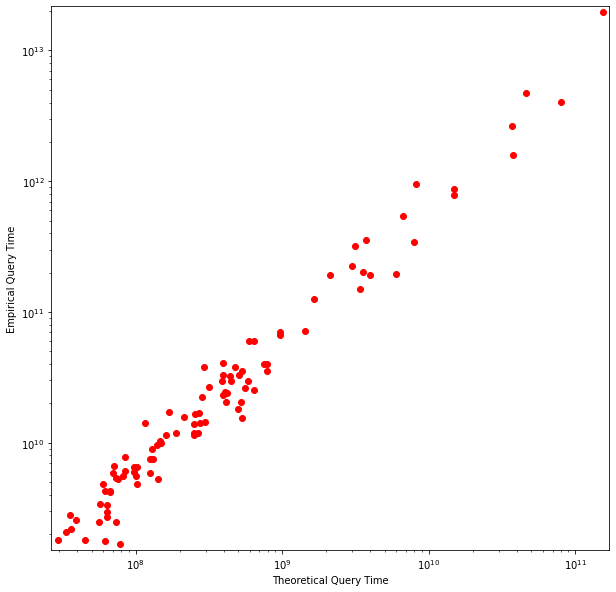

In [53]:
# plot shows that this is consistent with the theoritical query time
test_thresholding(trials = 100)

In [54]:
"""
general purpose partial derivative
"""
def partial_derivative(f,input):
    ret = np.empty(len(input))
    for i in range(len(input)):
        fg = lambda x:partial_function(f,input,i,x)
        ret[i] = nd.Derivative(fg)(input[i])
    return ret

In [55]:
"""
Comparing two functions 
"""
def compare_two_functions(n, f1,f2, mu, delta):
  def diff(*arr):
    return f1(*arr)-f2(*arr)
  decision, _, query_history , _  , guessed_total = adaptive_thresholding(n, diff ,mu, 0, delta, 0)
  return decision, query_history[-1] , guessed_total#gets the decision and how much queries are spent

  

In [56]:
"""
Toy Example on Function Comparision
"""

n = 2
def f1(*arr):
  return (2*arr[0]+3*arr[1])/1000
def f2(*arr):
  return (6.1*arr[0]-arr[1])/1000

mu = [1,1]
delta = 0.01
print(compare_two_functions(n,f1,f2,mu,delta))

(False, 10485761.0, [5363543.0, 5122218.0])


In [57]:
"""
Find maximum function with naive logic tournament style
"""
def find_maximum_naive(n, functions, mu, delta):
  l = len(functions)
  curr_max = 0
  queries = [0 for i in range(n)]
  for i in range(1,l):
    dec,tot,gt = compare_two_functions(n, functions[curr_max], functions[i], mu, delta / l)
    queries  = [max(queries[j] , gt[j]) for j in range(n)]
    if dec:
      pass
    else:
      curr_max = i
  return curr_max, queries


In [58]:
"""
Better find maximum function algorithm
"""
def find_maximum_adaptive(n, functions, mu, delta, omega):
  l = len(functions)
  d = 1
  queries = [0 for i in range(n)]
  candidates = set([i for i in range(l)])
  Lc = {}
  Uc = {}
  for c in candidates:
    Lc[c] = float('-inf')
    Uc[c] = float('inf')
  r = 1
  while len(candidates) > 1:
    for c in candidates:
      guess, _, query_history, arm_counts= adaptive_batch(n, functions[c], mu, d, delta/np.log(1/omega), np.random.randint(0,100))
      queries = [max(queries[i], arm_counts[i]) for i in range(n)] #reuse pulls
      xc = functions[c](*guess)
      Lc[c] = max(xc-d, Lc[c])
      Uc[c] = min(xc+d, Uc[c])
    maxlb = max(Lc, key = Lc.get)
    eliminated = set()
    for c in candidates:
      if Uc[c] < Lc[maxlb]:
        del Uc[c]
        del Lc[c]
        eliminated.add(c)
    for e in eliminated:
      candidates.remove(e)
    d = d/2
    r = r+1
  return list(candidates)[0], queries





In [59]:
"""
get omega and omega*
"""
def get_omegas(functions, mu):
  array = [f(*mu) for f in functions]
  array.sort(reverse = True)
  ans = []
  for i in range(1, len(functions)):
    ans.append(array[0] - array[i])
  return ans

def get_min_distance(functions, mu):
  array = [f(*mu) for f in functions]
  omega = float('inf')
  for i in range(len(functions)):
    for j in range(i+1, len(functions)):
      omega = min(omega, abs(array[i] - array[j]))
  return omega

In [60]:
"""
trial test
"""
n = 2

def f1(*arr):
  return (7*arr[0]-arr[1])/100000
def f2(*arr):
  return (6*arr[0]+arr[1])/100000
def f3(*arr):
  return (20*arr[0]+3*arr[1])/1000
def f4(*arr):
  return (7*arr[0]+3*arr[1])/1000
def f5(*arr):
  return (6*arr[0]+5*arr[1])/1000
def f6(*arr):
  return (7*arr[0]-6*arr[1])/1000
def f7(*arr):
  return (10*arr[0]+3*arr[1])/1000
def f8(*arr):
  return (7*arr[0]+11*arr[1])/1000
def f9(*arr):
  return (11*arr[0]+9*arr[1])/1000
def f10(*arr):
  return (arr[0]+arr[1])/1000
mu = [1,1]
functions = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10]
delta = 0.01
omega = get_omegas(functions,mu)
min_dist = get_min_distance(functions, mu)

print(omega, min_dist)
print(find_maximum_adaptive(n, functions, mu, delta,omega[0]))
print(find_maximum_naive(n, functions, mu, delta))

[0.002999999999999999, 0.005000000000000001, 0.01, 0.012, 0.013, 0.020999999999999998, 0.022, 0.02293, 0.02294] 9.999999999999992e-06
(2, [403626.0, 192683.0])
(2, [41943040.0, 41943040.0])


In [61]:
for i in range(100):
  ansa , tota = find_maximum_adaptive(n, functions, mu, delta,omega[0])
  ansb , totb = find_maximum_naive(n, functions, mu, delta)

  assert(ansa == 2)
  assert(ansb == 2)


In [62]:
"""
Create testcase. Big function is the designed "winner"
"""
def generate_function(n):
  r = np.random.normal(loc = n/2, size = n) 
  def f(*mu):
    ans = 0
    for i in range(len(mu)):
      ans = ans + r[i] * mu[i]
    return ans/(n**4)
  return f

def generate_big_function(n):
  r = np.random.normal(loc = n/2, size = n) 
  def f(*mu):
    ans = 0
    for i in range(len(mu)):
      ans = ans + r[i] * mu[i]
    return ans/(n**3)
  return f


In [63]:
"""
Testing our maximum function algorithm
"""
def find_max_test(n = 5, fns = 5, rounds = 20):

  diffs = []
  times = []
  for r in range(rounds):  
    functions = []
    mu = np.random.normal(loc = n/2, size = n)
    t = np.random.randint(int(n*0.8), n)
    
    for i in range(fns):
      if i != t:
        functions.append(generate_function(n))
      else:
        functions.append(generate_big_function(n))
    omega = get_omegas(functions,mu)
    min_dist = get_min_distance(functions, mu)
    ansa , tota = find_maximum_adaptive(n, functions, mu, 0.01,omega[0])
    ansb , totb = find_maximum_naive(n, functions, mu, 0.01)
    if sum(totb)/sum(tota) != 1:
      diffs.append(omega[0]/min_dist)
      times.append(sum(totb)/sum(tota))
  plt.figure(figsize = (10,10))
  plt.yscale('log')
  plt.xscale('log')
  plt.ylabel('Empirical Gain')
  plt.xlabel('Ratio of Distance')
  plt.xlim(min(diffs)*0.9, max(diffs)*1.1) # restricts x axis from 0 to 25
  plt.ylim(min(times)*0.9, max(times)*1.1) # restricts x axis from 0 to 25
  plt.scatter(diffs,times, color = 'r')



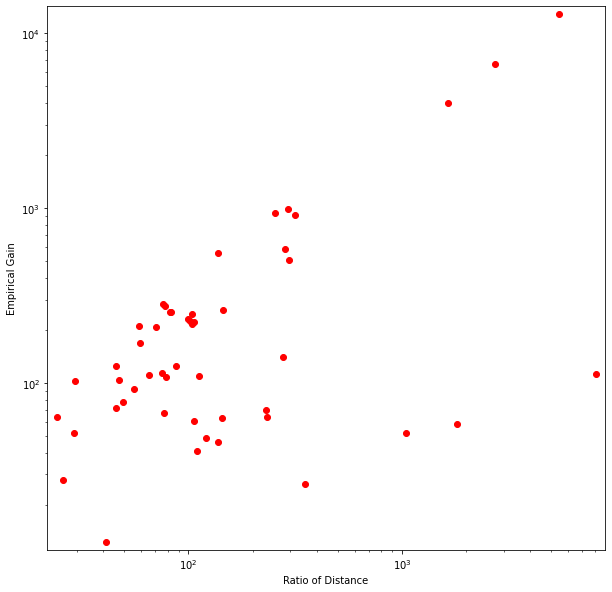

In [64]:
find_max_test(n = 5, fns = 5, rounds = 50)

In [65]:
"""
Find best mu for a fix function
"""
def find_best_mu_adaptive(n, f, mus, delta, dist):
  l = len(mus)
  d = 1
  queries = 0
  candidates = set([i for i in range(l)])
  Lc = {}
  Uc = {}
  for c in candidates:
    Lc[c] = float('-inf')
    Uc[c] = float('inf')
  r = 1
  while len(candidates) > 1:
    for c in candidates:
      guess, _, query_history, _ = adaptive_batch(n, f, mus[c], d, delta/(l*np.log(1/dist)), 0)
      xc = f(*guess)
      queries = queries + query_history[-1]
      Lc[c] = max(xc-d, Lc[c])
      Uc[c] = min(xc+d, Uc[c])
    maxlb = max(Lc, key = Lc.get)
    eliminated = set()
    for c in candidates:
      if Uc[c] < Lc[maxlb]:
        del Uc[c]
        del Lc[c]
        eliminated.add(c)
    for e in eliminated:
      candidates.remove(e)
    d = d/2
    r = r+1
  return list(candidates)[0], queries



In [66]:
"""
Get Deltas and Deltas*
"""
def get_deltas(f, mus):
  array = [f(*mu) for mu in mus]
  array.sort(reverse = True)
  ans = []
  for i in range(1, len(mus)):
    ans.append(array[0] - array[i])
  return ans

def get_min_eval(f, mus):
  array = [f(*mu) for mu in mus]
  delta = float('inf')
  for i in range(len(mus)):
    for j in range(i+1, len(mus)):
      delta = min(delta, abs(array[i] - array[j]))
  return delta

In [67]:
"""
Calculate expected pulls theoritically
"""
def expected_pulls(f, mus, delta,n):
  ans = 0
  k = len(mus)
  d = get_deltas(f, mus)
  d.append(d[0])
  s = max([sum(partial_derivative(f,mus[i]))**2 for i in range(len(mus))])
  print(s)
  for i in range(len(mus)):
    ans = ans + k*s*s* np.log(np.log(1/d[i])* k / delta) / (d[i]**2) + (k *n*n*np.log(1/d[i]) * k) /(delta * d[i])
  return ans

In [68]:
"""
Toy example for small n, mu
"""
n = 2
def f1(*arr):
  return (2*arr[0]+3*arr[1])/20000

mu1 = [1,1] 
mu2 = [0,1]
mu3 = [2,1]
mus = [mu1,mu2,mu3]
delta = 0.01

d = get_deltas(f1,mus)
print(find_best_mu_adaptive(n, f1, mus, delta,d[0]))
print(expected_pulls(f1,mus,delta,n))

(2, 62907842.0)
6.250000000000002e-08
816453984.2277985


In [69]:
"""
Test for largest mu
"""
def find_max_test(n = 5, mus = 5, rounds = 20):

  expect = []
  actual = []
  
  for r in range(rounds):  
    mul = []
    f = generate_function(n)
    
    for i in range(mus):
      mu = np.random.normal(loc = n/2, size = n)
      mul.append(mu)
    delta = get_deltas(f,mul)
    ansa , tota = find_best_mu_adaptive(n, f, mul, 0.01,delta[0])
    actual.append(tota)
    expect.append(expected_pulls(f,mul,0.01,n))
  plt.figure(figsize = (10,10))
  plt.yscale('log')
  plt.xscale('log')
  plt.ylabel('Actual')
  plt.xlabel('Expected')
  plt.xlim(min(expect)*0.9, max(expect)*1.1) # restricts x axis from 0 to 25
  plt.ylim(min(actual)*0.9, max(actual)*1.1) # restricts x axis from 0 to 25
  plt.scatter(expect,actual, color = 'r')



0.0008196191372813352
0.0005338598660100714
0.0003699637537781279
0.0003984747631917555
0.0004267368683107996
0.0005064723355913842
0.0003824825755056852
0.00033502957511029845
0.0002914701659519187
0.0004444060825353914
0.0003209864712099652
0.0001723707245236127
0.00035198030473489845
0.0004586853562272188
0.0005319615642340427
0.00048596157888092234
0.0002433480842590662
0.00043329661367951265
0.00034670326382901903
0.00019130075217702082


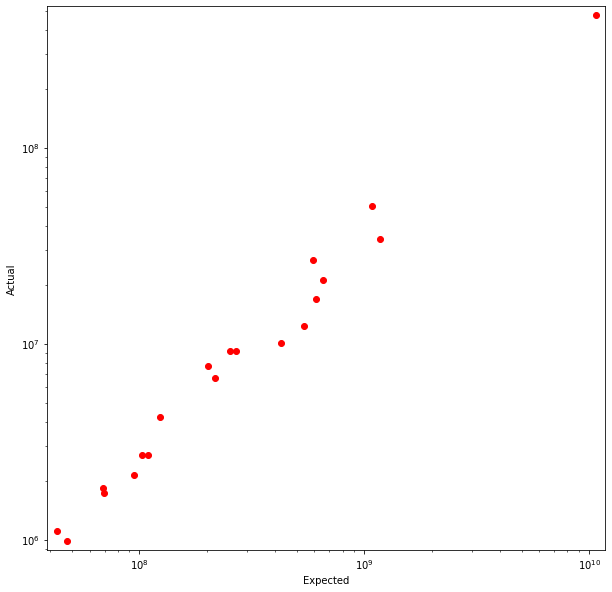

In [70]:
find_max_test()